## Import libraries, dataset and read it

In [3]:
import pandas as pd
import numpy as np

In [4]:
from datasets import load_dataset

dataset = load_dataset("bwbayu/job_cv_supervised")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'clean_cv', 'clean_jd', 'label'],
        num_rows: 31203
    })
})

In [6]:
df = dataset['train'].to_pandas().reset_index(drop=True)

In [7]:
df

,Unnamed: 0,clean_cv,clean_jd,label
0,0,result oriented organized bilingual accounting...,minimum education requirement bachelor degree ...,1
1,1,result oriented organized bilingual accounting...,hiring talented candidate join accounting team...,1
2,2,result oriented organized bilingual accounting...,duty proficient working excel skilled working ...,1
3,3,result oriented organized bilingual accounting...,job description responsible supervising checki...,1
4,4,result oriented organized bilingual accounting...,qualification one bachelor degree finance acco...,1
...,...,...,...,...
31198,31198,watch officer watch officer watch officer gnos...,halo learn grow skill award winning startup te...,0
31199,31199,watch officer watch officer watch officer gnos...,qualification maximum age twenty eight year ol...,0
31200,31200,watch officer watch officer watch officer gnos...,responsibility learn real case situation under...,0
31201,31201,watch officer watch officer watch officer gnos...,job purpose ensure application development pri...,0


In [8]:
del df['Unnamed: 0']

In [9]:
df.head()

,clean_cv,clean_jd,label
0,result oriented organized bilingual accounting...,minimum education requirement bachelor degree ...,1
1,result oriented organized bilingual accounting...,hiring talented candidate join accounting team...,1
2,result oriented organized bilingual accounting...,duty proficient working excel skilled working ...,1
3,result oriented organized bilingual accounting...,job description responsible supervising checki...,1
4,result oriented organized bilingual accounting...,qualification one bachelor degree finance acco...,1


In [10]:
df = df.rename(columns={'clean_cv': 'resume_text'})
df = df.rename(columns={'clean_jd': 'job_description_text'})

## EDA and feature engineering

In [11]:
df.isnull().sum()

resume_text             0
job_description_text    0
label                   0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31203 entries, 0 to 31202
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   resume_text           31203 non-null  object
 1   job_description_text  31203 non-null  object
 2   label                 31203 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 731.4+ KB


In [13]:
#1 = CV matches / candidate fits job, 0 = does not match
df['label'].value_counts(normalize=True)

label
1    0.503734
0    0.496266
Name: proportion, dtype: float64

In [14]:
df_text = pd.DataFrame()

df_text['resume_len'] = df['resume_text'].apply(len)
df_text['job_len'] = df['job_description_text'].apply(len)

print(df_text[['resume_len', 'job_len']].describe())

         resume_len       job_len
count  31203.000000  31203.000000
mean    3892.873794   1609.138929
std     3108.458738   1310.820590
min      112.000000    142.000000
25%     1638.000000    655.000000
50%     3502.000000   1122.000000
75%     5039.000000   2127.000000
max    21044.000000   6080.000000


In [15]:
df.head()

,resume_text,job_description_text,label
0,result oriented organized bilingual accounting...,minimum education requirement bachelor degree ...,1
1,result oriented organized bilingual accounting...,hiring talented candidate join accounting team...,1
2,result oriented organized bilingual accounting...,duty proficient working excel skilled working ...,1
3,result oriented organized bilingual accounting...,job description responsible supervising checki...,1
4,result oriented organized bilingual accounting...,qualification one bachelor degree finance acco...,1


In [16]:
df['resume_text'].nunique()

637

In [17]:
df['job_description_text'].nunique()

452

In [18]:
df['combined_text'] = df['resume_text'] + " [SEP] " + df['job_description_text']
df['combined_text'].nunique()

31203

In [19]:
df.head()

,resume_text,job_description_text,label,combined_text
0,result oriented organized bilingual accounting...,minimum education requirement bachelor degree ...,1,result oriented organized bilingual accounting...
1,result oriented organized bilingual accounting...,hiring talented candidate join accounting team...,1,result oriented organized bilingual accounting...
2,result oriented organized bilingual accounting...,duty proficient working excel skilled working ...,1,result oriented organized bilingual accounting...
3,result oriented organized bilingual accounting...,job description responsible supervising checki...,1,result oriented organized bilingual accounting...
4,result oriented organized bilingual accounting...,qualification one bachelor degree finance acco...,1,result oriented organized bilingual accounting...


## Split the data

Since the same CV appears in multiple CV–JD pairs, used a group-based split by CV to prevent data leakage and ensure realistic evaluation.

In [20]:
# from sklearn.model_selection import train_test_split

# df_train, df_temp = train_test_split(df, test_size=0.3, random_state=1, stratify=df['label'])
# df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=1, stratify=df_temp['label'])


# df_train = df_train.reset_index(drop=True)
# df_val = df_val.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

# y_train = df_train.label.values
# y_val = df_val.label.values
# y_test = df_test.label.values

# del df_train['label']
# del df_val['label']
# del df_test['label']

In [21]:
from sklearn.model_selection import train_test_split

#Get unique CVs
unique_cvs = df['resume_text'].unique()

# Split CVs
train_cvs, temp_cvs = train_test_split(
    unique_cvs, test_size=0.3, random_state=1
)

val_cvs, test_cvs = train_test_split(
    temp_cvs, test_size=0.5, random_state=1
)

# Create splits
df_train = df[df['resume_text'].isin(train_cvs)]
df_val   = df[df['resume_text'].isin(val_cvs)]
df_test  = df[df['resume_text'].isin(test_cvs)]

# Reset index
df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

y_train = df_train.label.values
y_val = df_val.label.values
y_test = df_test.label.values

del df_train['label']
del df_val['label']
del df_test['label']

### Converting Resume Text and Job Description Text into Vectors and Computing Cosine Similarity as a New Feature

#### TF-IDF Vectorizer
- Converts text into numbers that reflect how important each word is in a document relative to the whole collection of documents.
- **Output:** A numeric vector for each document, where each element represents the TF-IDF score of a word from the vocabulary.

#### Cosine Similarity
- Computes the angle between the two TF-IDF vectors.
- `1` → texts are very similar
- `0` → texts are completely different

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# TF-IDF Vectorizer
# Create SHARED vocabulary for cosine similarity
shared_tfidf = TfidfVectorizer(max_features=5000)

# Fit on BOTH resumes and JDs
all_train_text = pd.concat([
    df_train['resume_text'], 
    df_train['job_description_text']
])
shared_tfidf.fit(all_train_text)


X_train_resume = shared_tfidf.transform(df_train['resume_text'])
X_train_jd     = shared_tfidf.transform(df_train['job_description_text'])

X_val_resume = shared_tfidf.transform(df_val['resume_text'])
X_val_jd     = shared_tfidf.transform(df_val['job_description_text'])

X_test_resume = shared_tfidf.transform(df_test['resume_text'])
X_test_jd     = shared_tfidf.transform(df_test['job_description_text'])


# Function to compute cosine similarity row-wise
def rowwise_cosine(X1, X2):
    X1_norm = normalize(X1)
    X2_norm = normalize(X2)
    return np.array(X1_norm.multiply(X2_norm).sum(axis=1)).ravel()

# Compute cosine similarity efficiently
cos_sim_train = rowwise_cosine(X_train_resume, X_train_jd)
cos_sim_val   = rowwise_cosine(X_val_resume, X_val_jd)
cos_sim_test  = rowwise_cosine(X_test_resume, X_test_jd)

In [23]:
from scipy.sparse import hstack

tfidf = TfidfVectorizer(max_features=5000)

X_train_combined = tfidf.fit_transform(df_train['combined_text'])
X_val_combined   = tfidf.transform(df_val['combined_text'])
X_test_combined  = tfidf.transform(df_test['combined_text'])

X_train_final = hstack([X_train_combined, cos_sim_train.reshape(-1, 1)])
X_val_final = hstack([X_val_combined, cos_sim_val.reshape(-1, 1)])
X_test_final = hstack([X_test_combined, cos_sim_test.reshape(-1, 1)])

### check features ranges

In [24]:
# Check TF-IDF range
print("TF-IDF Combined features range:")
print(f"  Min: {X_train_combined.min():.6f}")
print(f"  Max: {X_train_combined.max():.6f}")
print(f"  Mean: {X_train_combined.mean():.6f}")

# Check cosine similarity range  
print("\nCosine similarity range:")
print(f"  Min: {cos_sim_train.min():.3f}")
print(f"  Max: {cos_sim_train.max():.3f}")
print(f"  Mean: {cos_sim_train.mean():.3f}")

TF-IDF Combined features range:
  Min: 0.000000
  Max: 0.842677
  Mean: 0.002666

Cosine similarity range:
  Min: 0.000
  Max: 0.601
  Mean: 0.083


In [25]:
#feature_names = list(tfidf.get_feature_names_out()) + ['cosine_similarity']
#feature_names

### Training the model with logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
for C in [0.001, 0.01, 0.1, 1, 10]: 
    model = LogisticRegression(max_iter=1000, C=C)
    model.fit(X_train_final, y_train)
    
    y_val_proba = model.predict_proba(X_val_final)[:, 1]
    auc = roc_auc_score(y_val, y_val_proba)
    
    print('%4s -> %.3f' % (C, auc))

0.001 -> 0.768
0.01 -> 0.829
 0.1 -> 0.894
   1 -> 0.911
  10 -> 0.909


In [32]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_final, y_train)

# Get predictions
y_val_proba = model.predict_proba(X_val_final)[:, 1]
y_pred = model.predict(X_val_final)

print(f"Accuracy: {accuracy_score(y_val, y_pred):.2%}")

Accuracy: 72.86%


In [33]:
auc_val = roc_auc_score(y_val, y_val_proba)
print("Validation AUC:", auc_val)

Validation AUC: 0.9106833672611366


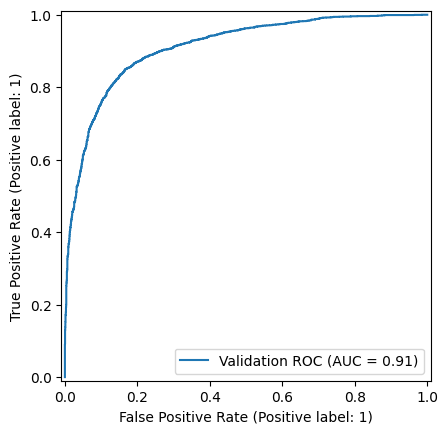

In [34]:
RocCurveDisplay.from_predictions(y_val, y_val_proba, name="Validation ROC")
plt.show()

In [35]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.49      0.64      2381
           1       0.66      0.96      0.78      2391

    accuracy                           0.73      4772
   macro avg       0.79      0.73      0.71      4772
weighted avg       0.79      0.73      0.71      4772



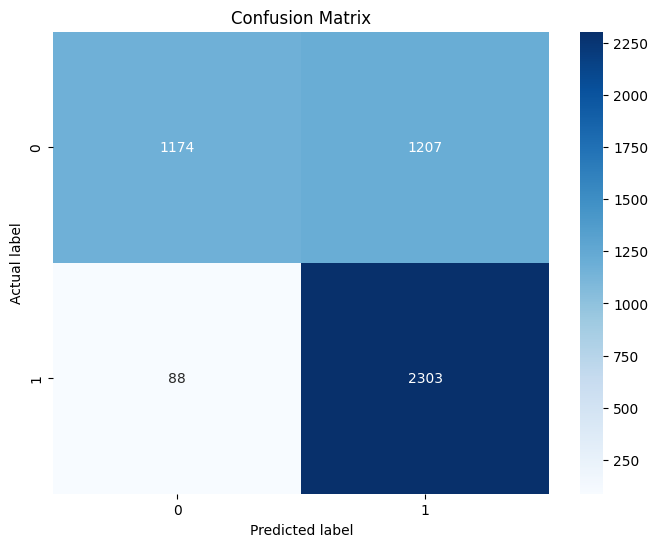

In [38]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Class names (adjust if your labels are different)
class_names = [0, 1]

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion Matrix")
plt.show()


### Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_final, y_train)

y_val_proba = dt.predict_proba(X_val_final)[:, 1]
y_pred = dt.predict(X_val_final)

auc_val = roc_auc_score(y_val, y_val_proba)
print("Validation AUC:", auc_val)

Validation AUC: 0.6679305937093303


In [41]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

print("Depth -> Auc")
print("-" * 50)

for depth in depths: 
    dt = DecisionTreeClassifier(
        max_depth=depth,
        class_weight='balanced',
        random_state=42
    )
    dt.fit(X_train_final, y_train)
    
    y_val_proba = dt.predict_proba(X_val_final)[:, 1]
    
    auc = roc_auc_score(y_val, y_val_proba)
    
    print(f'{str(depth):>4} -> {auc:>11.3f}')

Depth -> Auc
--------------------------------------------------
   1 ->       0.682
   2 ->       0.713
   3 ->       0.736
   4 ->       0.736
   5 ->       0.731
   6 ->       0.702
  10 ->       0.677
  15 ->       0.659
  20 ->       0.676
None ->       0.668


In [ ]:
#max_depth = 3

In [44]:
depths = [2, 3, 4, 5, 6]

print("Depth | Min Leaf | AUC")
print("-" * 50)

for depth in depths:
    for min_leaf in [1, 5, 10, 15, 20, 100, 200]:
        dt = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_leaf=min_leaf,
            class_weight='balanced',
            random_state=42
        )
        dt.fit(X_train_final, y_train)
        
        y_val_proba = dt.predict_proba(X_val_final)[:, 1]
    
        auc = roc_auc_score(y_val, y_val_proba)
        
        print(f'{str(depth):>4} | {min_leaf:>9} | {auc:>11.3f}')

Depth | Min Leaf | AUC
--------------------------------------------------
   2 |         1 |       0.713
   2 |         5 |       0.713
   2 |        10 |       0.713
   2 |        15 |       0.713
   2 |        20 |       0.713
   2 |       100 |       0.713
   2 |       200 |       0.713
   3 |         1 |       0.736
   3 |         5 |       0.736
   3 |        10 |       0.736
   3 |        15 |       0.736
   3 |        20 |       0.736
   3 |       100 |       0.736
   3 |       200 |       0.716
   4 |         1 |       0.736
   4 |         5 |       0.736
   4 |        10 |       0.736
   4 |        15 |       0.736
   4 |        20 |       0.736
   4 |       100 |       0.754
   4 |       200 |       0.737
   5 |         1 |       0.731
   5 |         5 |       0.731
   5 |        10 |       0.731
   5 |        15 |       0.729
   5 |        20 |       0.730
   5 |       100 |       0.748
   5 |       200 |       0.719
   6 |         1 |       0.702
   6 |         5 |       0.

In [ ]:
#Depth = 4, min_samples_leaf = 100

In [48]:
dt = DecisionTreeClassifier(
            max_depth=4,
            min_samples_leaf=100,
            class_weight='balanced',
            random_state=42
        )
dt.fit(X_train_final, y_train)
        
y_val_proba = dt.predict_proba(X_val_final)[:, 1]
y_pred = dt.predict(X_val_final)
    
auc_val = roc_auc_score(y_val, y_val_proba)
print("Validation AUC:", auc_val)

Validation AUC: 0.7544467554814526


In [49]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.78      0.71      2381
           1       0.73      0.58      0.65      2391

    accuracy                           0.68      4772
   macro avg       0.69      0.68      0.68      4772
weighted avg       0.69      0.68      0.68      4772



### Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

print("n_estimators -> AUC")
print("-" * 50)

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, class_weight='balanced', random_state=42, n_jobs=-1)
    rf.fit(X_train_final, y_train)
    
    y_pred = rf.predict(X_val_final)
    y_val_proba = rf.predict_proba(X_val_final)[:, 1]
    
    auc = roc_auc_score(y_val, y_val_proba)
        
    print(f'{str(n):>4} | {auc:>9}')

n_estimators -> AUC
--------------------------------------------------
  10 | 0.8222053124809525
  20 | 0.8764168129435403
  30 | 0.9000712457519985
  40 | 0.9076592872157614
  50 | 0.9106079233496887
  60 | 0.9064501645977118
  70 | 0.9050846210177428
  80 | 0.902659525228567
  90 | 0.9059835365400597
 100 | 0.907392379128578
 110 | 0.9066521680858729
 120 | 0.9072208518188483
 130 | 0.9119803174827343
 140 | 0.9118952125348961
 150 | 0.9112126164001186
 160 | 0.9131661657858436
 170 | 0.9151903285648214
 180 | 0.9139058498629274
 190 | 0.9158817074599537
 200 | 0.9157059644252535


In [55]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    class_weight='balanced',
                                    random_state=42,
                                    n_jobs=-1)
        rf.fit(X_train_final, y_train)

        y_val_proba = rf.predict_proba(X_val_final)[:, 1]
        auc = roc_auc_score(y_val, y_val_proba)

        scores.append((d, n, auc))

In [56]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

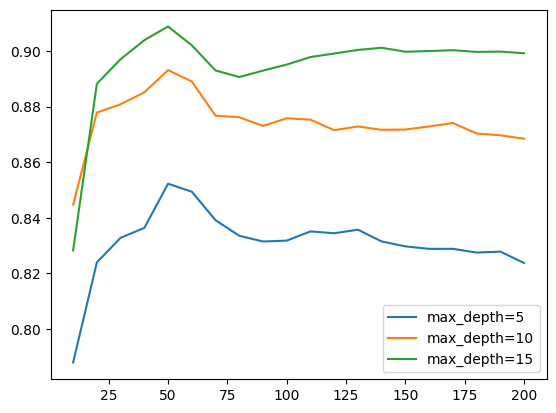

In [57]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [60]:
print("n_estimators | max_depth -> AUC")
print("-" * 50)

for n in range(10, 81, 10):
    for d in [15, 30, 40, 50]:
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    class_weight='balanced',
                                    random_state=42,
                                    n_jobs=-1)
        rf.fit(X_train_final, y_train)
        
        y_pred = rf.predict(X_val_final)
        y_val_proba = rf.predict_proba(X_val_final)[:, 1]
        
        auc = roc_auc_score(y_val, y_val_proba)
            
        print(f'{str(n):>4} | {str(d):>4}  | {auc:>9}')

n_estimators | max_depth -> AUC
--------------------------------------------------
  10 |   15  | 0.8283023925468792
  10 |   30  | 0.8884236367970257
  10 |   40  | 0.8563469759463029
  10 |   50  | 0.8471011884655657
  20 |   15  | 0.8882390231743671
  20 |   30  | 0.9212342729306016
  20 |   40  | 0.8811248994593508
  20 |   50  | 0.8761465674074222
  30 |   15  | 0.89706218422683
  30 |   30  | 0.9215477296476655
  30 |   40  | 0.8920681310338663
  30 |   50  | 0.8918733294091961
  40 |   15  | 0.9039194122014674
  40 |   30  | 0.9271183710579239
  40 |   40  | 0.9043139337966064
  40 |   50  | 0.8983901375924803
  50 |   15  | 0.9088352109996696
  50 |   30  | 0.9244931161602614
  50 |   40  | 0.9107675939329395
  50 |   50  | 0.9104024945849891
  60 |   15  | 0.9020552713161547
  60 |   30  | 0.913389511381667
  60 |   40  | 0.9081612219700399
  60 |   50  | 0.9088122879951435
  70 |   15  | 0.8930126290824246
  70 |   30  | 0.9082089123587668
  70 |   40  | 0.9129533595024462
  

In [67]:
n = 50
d = 30

In [68]:
rf = RandomForestClassifier(n_estimators=n,
                            max_depth=d,
                            class_weight='balanced',
                            random_state=42,
                            n_jobs=-1)
rf.fit(X_train_final, y_train)

y_pred = rf.predict(X_val_final)
y_val_proba = rf.predict_proba(X_val_final)[:, 1]
    
auc = roc_auc_score(y_val, y_val_proba)
auc

0.9244931161602615

In [69]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.44      0.60      2381
           1       0.63      0.97      0.77      2391

    accuracy                           0.70      4772
   macro avg       0.79      0.70      0.68      4772
weighted avg       0.79      0.70      0.68      4772



### XGBoost